In [29]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from aerobot.io import RESULTS_PATH, load_results_dict
from aerobot.dataset import dataset_load_all, dataset_load_feature_order
from aerobot.models import GeneralClassifier
import os
from typing import Dict, List
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Some specs to make plots look nice. 
TITLE_FONT_SIZE, LABEL_FONT_SIZE = 12, 8
PALETTE = 'Paired'
# Set all matplotlib global parameters.
plt.rc('font', **{'family':'sans-serif', 'sans-serif':['Arial'], 'size':LABEL_FONT_SIZE})
plt.rc('xtick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('ytick', **{'labelsize':LABEL_FONT_SIZE})
plt.rc('axes',  **{'titlesize':TITLE_FONT_SIZE, 'labelsize':LABEL_FONT_SIZE})
# plt.rcParams['image.cmap'] = 'Paired'
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Paired.colors)

In [7]:
# TODO: Work this in to the io.py module. Also add other feature types. 
PRETTY_NAMES = {'KO':'All gene families', 'embedding.geneset.oxygen':'Five-gene set', 'chemical':'Chemical features', 'aa_1mer':'Amino acid counts', 'aa_3mer':'Amino acid trimers'}
PRETTY_NAMES.update({'embedding.genome':'Genome embedding', 'metadata':'Metadata'})
PRETTY_NAMES.update({f'nt_{i}mer':f'Nucleotide {i}-mer' for i in range(1, 6)})
PRETTY_NAMES.update({f'cds_{i}mer':f'CDS {i}-mer' for i in range(1, 6)})
PRETTY_NAMES.update({f'aa_{i}mer':f'Amino acid {i}-mer' for i in range(2, 3)})

In [8]:
# For coloring the annotated and unannotated feature types differently. 
ANNOTATED = ['KO', 'embedding.geneset.oxygen'] 
UNANNOTATED = ['chemical', 'aa_1mer', 'aa_3mer']
FEATURE_TYPES = ANNOTATED + UNANNOTATED # A minimal list of feature types. 

## Loading results

In [9]:
phylo_bias_results = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_nonlinear_aa_3mer.json'))

In [10]:
# Load in the results of each training run. 
nonlinear_results = dict() # Results of Nonlinear classifier. 
logistic_results = dict() # Results of LogisticRegression-based classifier. 

for feature_type in FEATURE_TYPES:
    filename = f'run_results_nonlinear_{feature_type}.json'
    nonlinear_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, 'run', filename))
    filename = f'run_results_logistic_{feature_type}.json'
    logistic_results[feature_type] = load_results_dict(os.path.join(RESULTS_PATH, 'run', filename))

## Figure 1

In [38]:
def plot_figure_1a(grid:GridSpec=None, fig:plt.Figure=None):
    '''Just a placeholder, the diagram describing annotation-ful versus annotation-free pipelines for
    predicting metabolism will go here.'''
    ax = fig.add_subplot(grid)
    ax.set_axis_off()
    #ax.set_visible(False)

In [70]:
def plot_figure_1b(nonlinear_results:Dict, logistic_results:Dict, grid:GridSpec=None, fig:plt.Figure=None):
    '''Plot comparing Nonlinear and Logistic ternary classifier performance on the holdout set.'''

    def _format_barplot_axes(ax:plt.Axes):
        random_baseline =  0.33 # Expected performance for random classifier on task. 
        # Label bins with the feature name. 
        ax.set_xticks(np.arange(0, len(FEATURE_TYPES), 1), [PRETTY_NAMES[f] for f in FEATURE_TYPES], rotation=45, ha='right')
        
        # Set up left y-axis with the balanced accuracy information. 
        ax.set_ylabel('balanced accuracy')
        ax.set_ylim(0, 1)
        ax.set_yticks(np.arange(0, 1.1, 0.1))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1)) # xmax is the number to divide by for the percentage.
        # Add a second set of y-ticks on the right to indicate percentage performance increase over random (33% accurate)
        new_ax = ax.twinx()
        new_ax.set_ylim(0, 1)
        yticks = np.round(100 * (np.arange(0, 1.1, 0.1) - random_baseline) / random_baseline, 0)
        ytick_labels = [f'{v:.0f}%' for v in yticks]
        new_ax.set_yticks(yticks, ytick_labels)
        new_ax.set_ylabel('percent above random')

        # Add horizontal line marking model performance with random classification. 
        ax.axhline(random_baseline, color='grey', linestyle='--', linewidth=2, zorder=-10)

    ax = fig.add_subplot(grid)

    # Extract the final balanced accuracies on from the results dictionaries. 
    nonlinear_val_accs  = [nonlinear_results[feature_type]['validation_acc'] for feature_type in FEATURE_TYPES]
    logistic_val_accs  = [logistic_results[feature_type]['validation_acc'] for feature_type in FEATURE_TYPES]

    colors = ['tab:blue'] * len(ANNOTATED) + ['tab:green'] * len(UNANNOTATED)
    ax.bar(np.arange(0, len(FEATURE_TYPES), 1) - 0.2, logistic_val_accs, width=0.4, label='logistic', color=colors, edgecolor='k', linewidth=0.5, hatch='///')
    ax.bar(np.arange(0, len(FEATURE_TYPES), 1) + 0.2, nonlinear_val_accs, width=0.4, label='nonlinear', color=colors, edgecolor='k', linewidth=0.5)

    # Custom legend. Colors indicate annotation-free or annotation-full, and hatching indicates model class. 

    # # Custom legend. Colors indicate annotation-free or annotation-full, and hatching indicates training or validation set. 
    # handles = [plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch='////')]
    # handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='k', linewidth=0.5, hatch=''))
    # handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='tab:blue', edgecolor='k', linewidth=0.5))
    # handles.append(plt.Rectangle((0, 0), 1, 1, facecolor='tab:green', edgecolor='k', linewidth=0.5))
    # labels = ['LogisticRegression', 'Nonlinear', 'annotated', 'unannotated']
    # plt.legend(handles, labels, ncol=2, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='upper left', bbox_to_anchor=(0.25, 0.99))
    # plt.legend(handles, labels, ncol=2, fontsize=7, columnspacing=0.3, handletextpad=0.3, loc='upper left', bbox_to_anchor=(0.25, 0.99))

    _format_barplot_axes(ax)


In [71]:
def plot_figure_1c(phylo_bias_results:Dict, grid:GridSpec=None, fig:plt.Figure=None, show_points:bool=True):
    '''Plots the results of a single run of phlogenetic bias analysis''' 
    ax = fig.add_subplot(grid)
    
    feature_type = phylo_bias_results['feature_type'] # Extract the feature type from the results dictionary. 
    levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species'][::-1]

    # Load in results for the baselines. 
    randrel_results = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_randrel.json'))
    meanrel_results = load_results_dict(os.path.join(RESULTS_PATH, 'phylo_bias', 'phylo_bias_results_meanrel.json'))

    colors = ['gray', 'black', 'tab:blue']
    linestyles = ['--', '--', '-']
    labels = ['MeanRelative', 'RandomRelative', None if phylo_bias_results is None else phylo_bias_results['model_class'].capitalize()]
    legend = []

    for i, results in enumerate([meanrel_results, randrel_results, phylo_bias_results]):
        if results is not None:
            # Plot the error bar, as well as scatter points for each level. 
            means = [results['scores'][level]['mean'] for level in levels] # Extract the mean F1 scores.
            errs = [results['scores'][level]['err'] for level in levels] # Extract the standard errors. 
            level_scores = [results['scores'][level]['scores'] for level in levels] # Extract the raw scores for each level. 
            # Convert the scores to points for a scatter plot. 
            scores_x = np.ravel([np.repeat(i + 1, len(s)) for i, s in enumerate(level_scores)])
            scores_y = np.ravel(level_scores)

            ax.errorbar(np.arange(1, len(levels) + 1), means, yerr=errs, c=colors[i], linestyle=linestyles[i], capsize=3)
        
            if show_points: # Only show the points if specified.
                ax.scatter(scores_x, scores_y, color=colors[i], s=3)
            
            legend.append(labels[i])

    ax.set_ylabel('balanced accuracy')
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(1, len(levels) + 1), labels=levels)
    ax.set_xlabel('holdout level')
    ax.legend(legend)


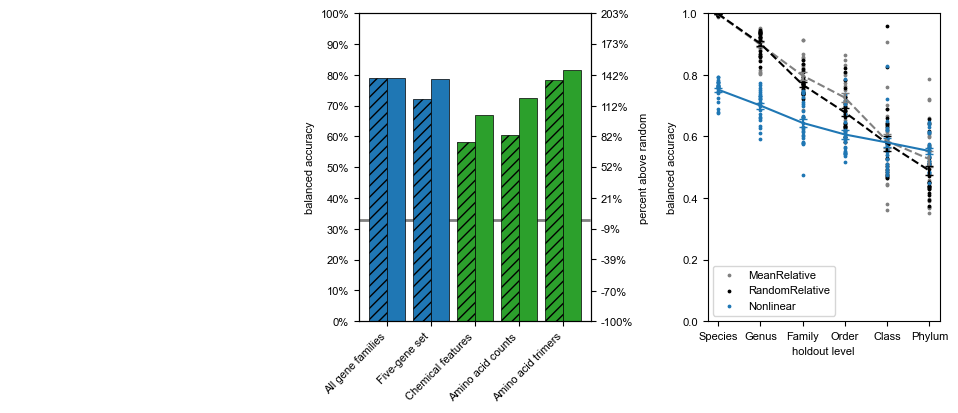

In [72]:
fig = plt.figure(figsize=(12, 4))
grid = GridSpec(1, 3, wspace=0.5) # width_ratios=[2, 2, 2])

plot_figure_1a(grid=grid[0, 0], fig=fig)
plot_figure_1b(nonlinear_results, logistic_results, grid=grid[0, 1], fig=fig)
plot_figure_1c(phylo_bias_results, grid=grid[0, 2], fig=fig)